- Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
import seaborn as sns
from mycolorpy import colorlist as mcp
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Use last 2 weeks as test set and validate the predictions
test_date = "2017-08-05"

# Data Source: https://www.kaggle.com/datasets/berkantaslan/municipality-bus-utilization

# 1) Data Reading and Pre-Processing

- Read and pre-processing the dataset

In [2]:
# read the dataset
bus_df = pd.read_csv("data/municipality_bus_utilization.csv", encoding="utf-8")
bus_df

timestamp  municipality_id  usage  total_capacity
0      2017-06-04 07:59:42                9    454            1332
1      2017-06-04 07:59:42                8    556            2947
2      2017-06-04 07:59:42                4   1090            3893
3      2017-06-04 07:59:42                0    204            2813
4      2017-06-04 07:59:42                7    718            2019
...                    ...              ...    ...             ...
13065  2017-08-19 16:30:35                2    548             697
13066  2017-08-19 16:30:35                8   1193            2947
13067  2017-08-19 16:30:35                7   1354            2019
13068  2017-08-19 16:30:35                6   1680            3113
13069  2017-08-19 16:30:35                3   1189            1930

[13070 rows x 4 columns]

In [3]:
bus_df.describe().T

count         mean          std    min    25%     50%  \
municipality_id  13070.0     4.500000     2.872391    0.0    2.0     4.5   
usage            13070.0   876.002984   679.287109   11.0  403.0   692.0   
total_capacity   13070.0  1972.800000  1144.074782  397.0  697.0  1974.5   

                    75%     max  
municipality_id     7.0     9.0  
usage            1190.0  3508.0  
total_capacity   2947.0  3893.0

In [4]:
bus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB


- It looks like timestamp column is string object. We should convert it to datetime object. 

In [5]:
bus_df["timestamp"] = pd.to_datetime(bus_df["timestamp"])
bus_df["timestamp"]

0       2017-06-04 07:59:42
1       2017-06-04 07:59:42
2       2017-06-04 07:59:42
3       2017-06-04 07:59:42
4       2017-06-04 07:59:42
                ...        
13065   2017-08-19 16:30:35
13066   2017-08-19 16:30:35
13067   2017-08-19 16:30:35
13068   2017-08-19 16:30:35
13069   2017-08-19 16:30:35
Name: timestamp, Length: 13070, dtype: datetime64[ns]

- We should standardize minutes to ease feature generation later

In [6]:
# get date, hour and minute information from timestamp
bus_df["date"] =  bus_df["timestamp"].apply(lambda x: x.date())
bus_df["hour"] =  bus_df["timestamp"].apply(lambda x: x.hour)
bus_df["minute"] =  bus_df["timestamp"].apply(lambda x: x.minute)

bus_df

timestamp  municipality_id  usage  total_capacity        date  \
0     2017-06-04 07:59:42                9    454            1332  2017-06-04   
1     2017-06-04 07:59:42                8    556            2947  2017-06-04   
2     2017-06-04 07:59:42                4   1090            3893  2017-06-04   
3     2017-06-04 07:59:42                0    204            2813  2017-06-04   
4     2017-06-04 07:59:42                7    718            2019  2017-06-04   
...                   ...              ...    ...             ...         ...   
13065 2017-08-19 16:30:35                2    548             697  2017-08-19   
13066 2017-08-19 16:30:35                8   1193            2947  2017-08-19   
13067 2017-08-19 16:30:35                7   1354            2019  2017-08-19   
13068 2017-08-19 16:30:35                6   1680            3113  2017-08-19   
13069 2017-08-19 16:30:35                3   1189            1930  2017-08-19   

       hour  minute  
0         7      59  
1         7      59  
2         7      59  
3         7      59  
4         7      59  
...     ...     ...  
13065    16      30  
13066    16      30  
13067    16      30  
13068    16      30  
13069    16      30  

[13070 rows x 7 columns]

In [7]:
# convert minutes to 00 or 30 depending on its closeness
def convert_minutes(df):

    if df["minute"] != 0 or df["minute"] != 30:
        if df["minute"] < 15:
            df["minute"] = 0
        elif df["minute"] < 30:
            df["minute"] = 30
        elif df["minute"] < 45:
            df["minute"] = 30
        else:
            df["minute"] = 0
            df["hour"] += 1

    return df

bus_df = bus_df.apply(lambda x: convert_minutes(x), axis=1)

In [8]:
# concatanete standardized time and convert it to datetime object
bus_df["timestamp"] = pd.to_datetime(
    bus_df.date.astype(str) + " " + bus_df.hour.astype(str) + ":" + bus_df.minute.astype(str) + ":00"
    )
    
bus_df["timestamp"]

0       2017-06-04 08:00:00
1       2017-06-04 08:00:00
2       2017-06-04 08:00:00
3       2017-06-04 08:00:00
4       2017-06-04 08:00:00
                ...        
13065   2017-08-19 16:30:00
13066   2017-08-19 16:30:00
13067   2017-08-19 16:30:00
13068   2017-08-19 16:30:00
13069   2017-08-19 16:30:00
Name: timestamp, Length: 13070, dtype: datetime64[ns]

In [9]:
# find average usage and capacitiy for each hour of the municipalities

for municipality in set(bus_df["municipality_id"]):
    temp_df = bus_df.query("municipality_id == @municipality")
    
    unique_dates = temp_df["date"].unique()

    for unique_date in unique_dates:
        hours = temp_df["hour"].unique()

        for hour in hours:
            hour_rows = temp_df.query("date == @unique_date").groupby("hour").get_group(hour)
            bus_df.loc[hour_rows.index, "usage"] = hour_rows["usage"].agg("mean")    
            bus_df.loc[hour_rows.index, "total_capacity"] = hour_rows["total_capacity"].agg("max")    

In [10]:
# drop minute=30 rows to use hourly usages
half_hour_ind = bus_df.query("minute == 30").index

bus_df.drop(half_hour_ind, axis=0, inplace=True)
bus_df.drop(columns=["date","minute"], axis=1, inplace=True)
bus_df.reset_index(inplace=True, drop=True)

bus_df

timestamp  municipality_id   usage  total_capacity  hour
0    2017-06-04 08:00:00                9   470.5            1332     8
1    2017-06-04 08:00:00                8   615.0            2947     8
2    2017-06-04 08:00:00                4  1283.0            3893     8
3    2017-06-04 08:00:00                0   225.5            2813     8
4    2017-06-04 08:00:00                7   753.5            2019     8
...                  ...              ...     ...             ...   ...
6525 2017-08-19 16:00:00                7  1402.0            2019    16
6526 2017-08-19 16:00:00                2   564.0             697    16
6527 2017-08-19 16:00:00                3  1259.5            1930    16
6528 2017-08-19 16:00:00                8  1223.0            2947    16
6529 2017-08-19 16:00:00                0  1273.5            2813    16

[6530 rows x 5 columns]

In [11]:
# check null values
bus_df.isna().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
hour               0
dtype: int64

- Since we have a time series dataset, we should use timestamps as index

In [12]:
# set timestamp column as index
bus_df.set_index("timestamp", inplace=True)

# 2) Exploratory Data Analysis

- Visualize and explore the data

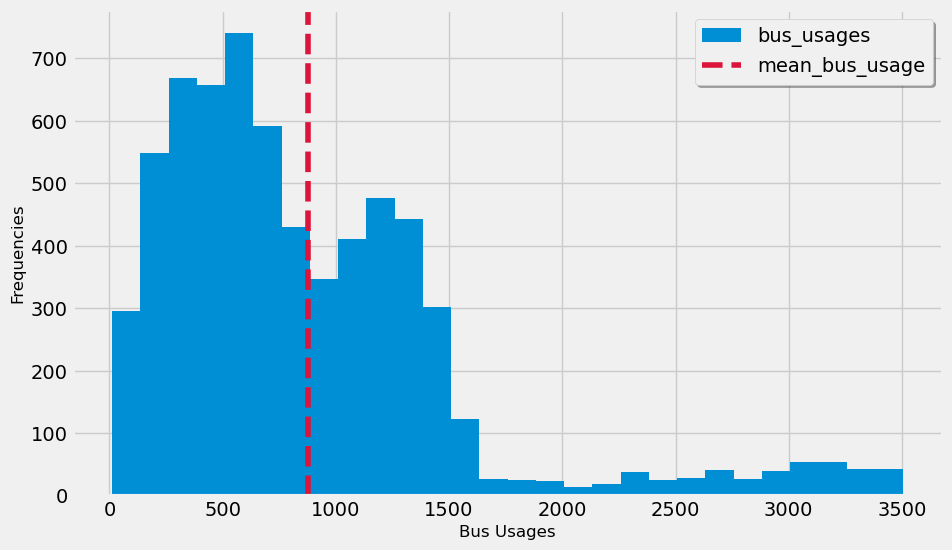

In [13]:
# plot bus usage frequencies
fig, ax = plt.subplots(figsize=(10,6))
bus_df["usage"].hist(bins="scott", ax=ax, label="bus_usages")
ax.axvline(np.mean(bus_df["usage"]), ls="dashed", color="crimson", label="mean_bus_usage")
plt.xlabel("Bus Usages", fontsize=12)
plt.ylabel("Frequencies", fontsize=12)
plt.legend(loc="best", shadow=True, fancybox=True)
plt.grid(True)
plt.show()

In [14]:
# remove first and last 1% of usage values since they can be considered as outliers
q = 0.01
lower_q = np.quantile(bus_df["usage"], q=q)
higher_q = np.quantile(bus_df["usage"], q=1-q)

len_org = len(bus_df)
bus_df = bus_df[(bus_df["usage"] > lower_q) & (bus_df["usage"] < higher_q)]
len_now = len(bus_df)

print("Total of", len_org - len_now, "outliers are removed")

Total of 132 outliers are removed


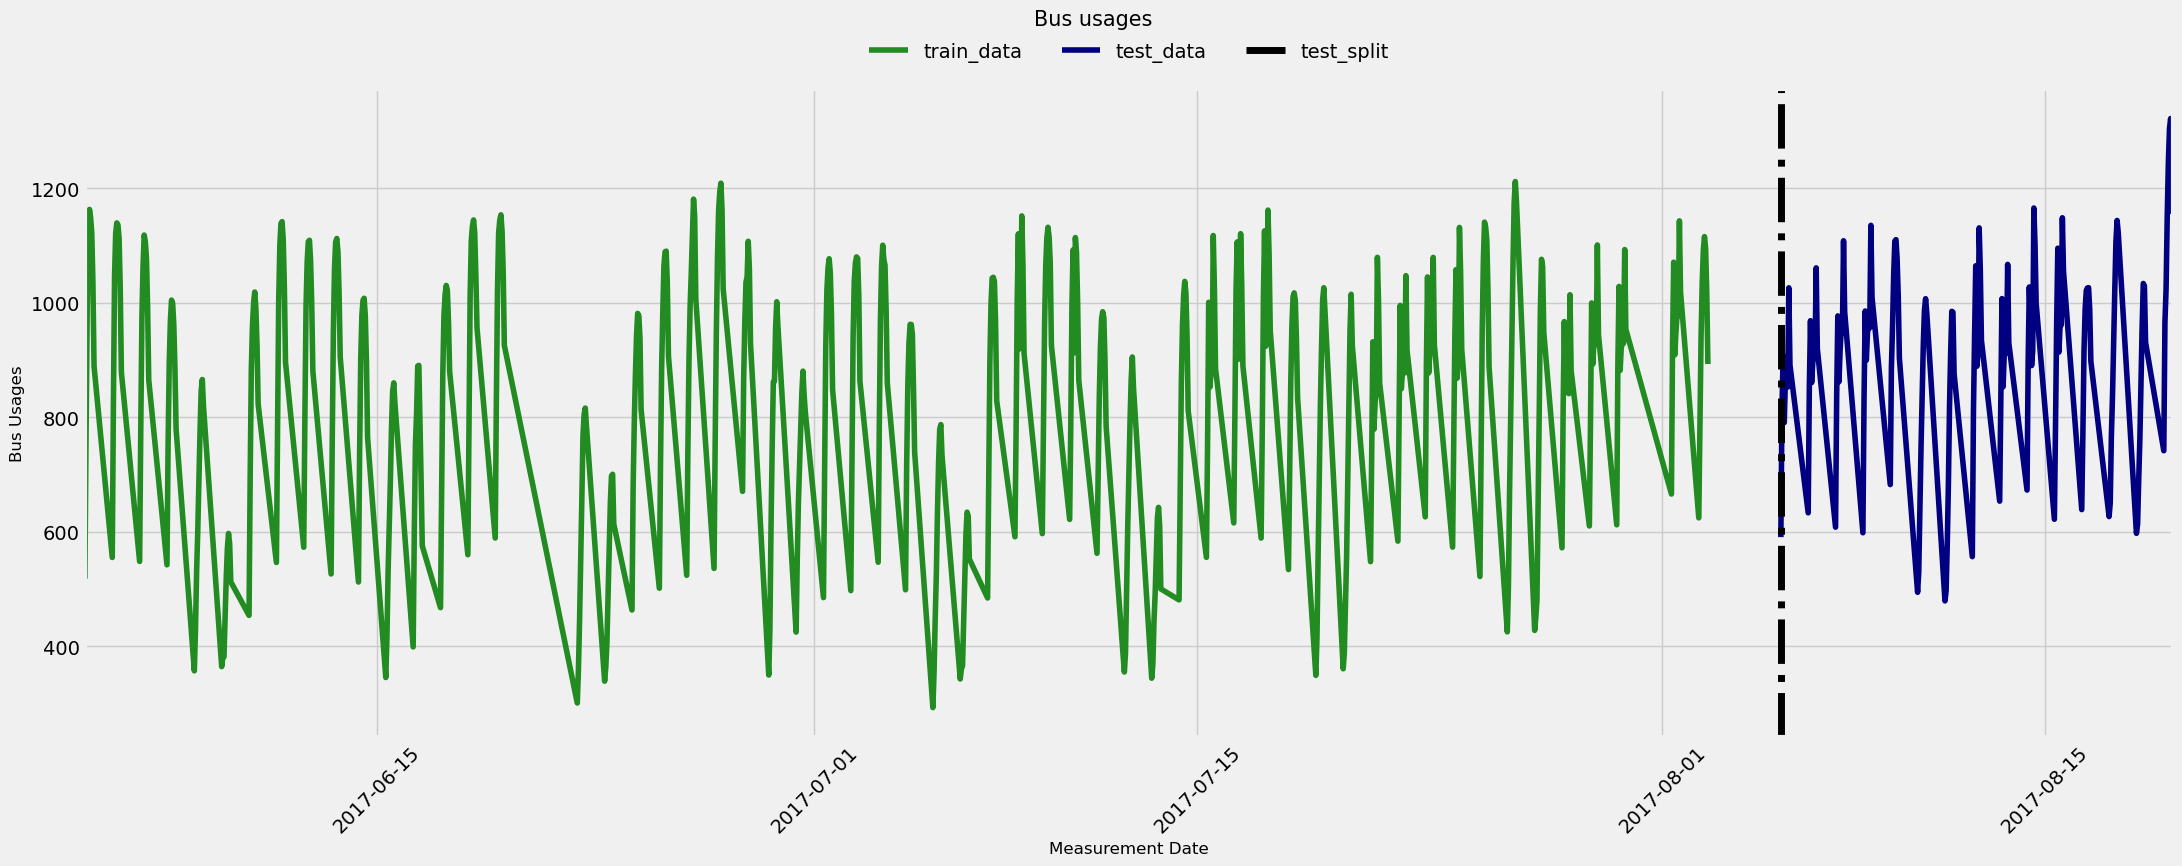

In [15]:
# plot the time series bus usages by municipalities
train = bus_df.loc[bus_df.index < test_date]
test = bus_df.loc[bus_df.index >= test_date]

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=train, x=train.index, y="usage", errorbar=None, label="train_data", c="forestgreen")
sns.lineplot(data=test, x=test.index, y="usage", errorbar=None, label="test_data", c="navy")
plt.axvline(test.index[0], lw=5, ls="dashdot", color="black", label="test_split") #add a line at test set date

plt.xlim([train.index.min(), test.index.max()])
plt.xticks(rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, frameon=False)

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages", fontsize=15)
plt.show()

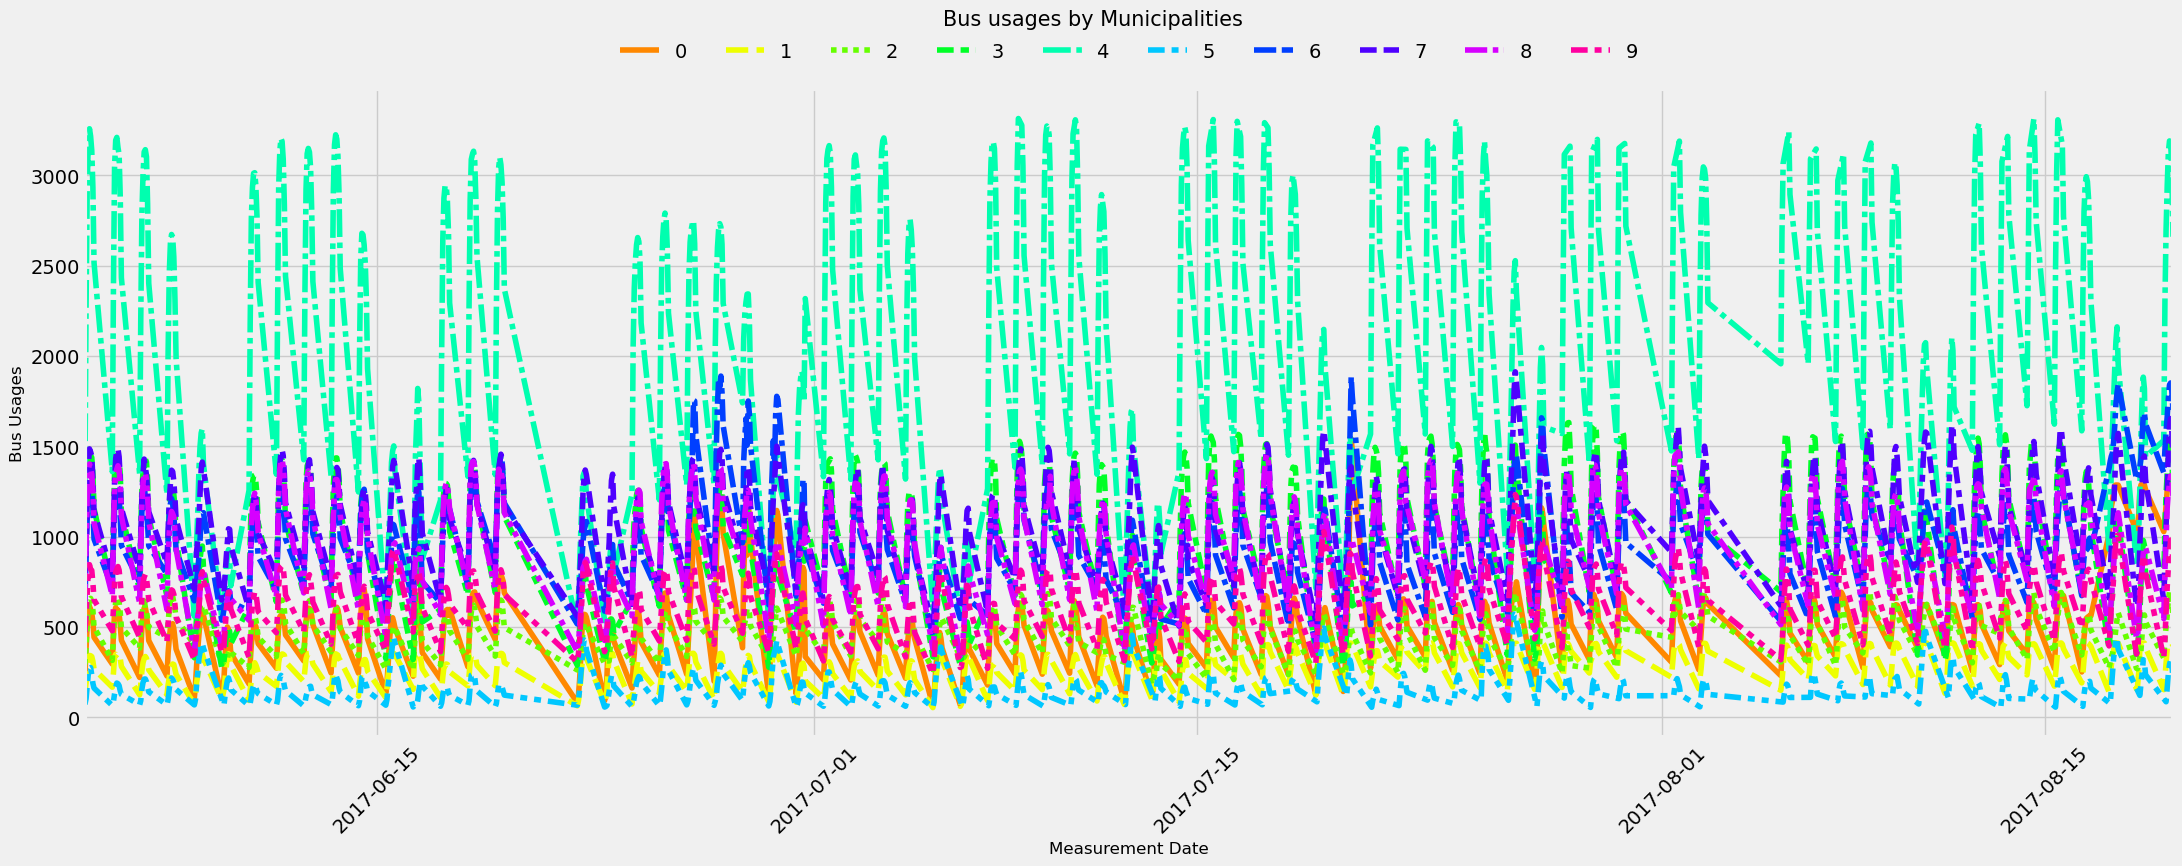

In [16]:
# plot the time series bus usages by municipalities
pivot_df = pd.pivot_table(data = bus_df, index=bus_df.index, values="usage", columns="municipality_id")

fig, ax = plt.subplots(figsize=(24,8))

sns.lineplot(data=pivot_df, palette="hsv")

plt.xlim([pivot_df.index.min(), pivot_df.index.max()])
plt.xticks(rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False, ncol=len(pivot_df.columns))

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages by Municipalities", fontsize=15)
plt.show()

In [17]:
pivot_df

municipality_id           0      1      2       3       4      5       6  \
timestamp                                                                  
2017-06-04 08:00:00   225.5  133.5  292.0   696.5  1283.0   71.5   642.0   
2017-06-04 09:00:00   380.5  188.5  389.0  1048.5  2263.5  102.5   871.0   
2017-06-04 10:00:00   509.5  259.0  516.5  1298.0  2927.5  172.5  1106.0   
2017-06-04 11:00:00   590.0  325.0  597.5  1416.5  3204.0  242.0  1234.5   
2017-06-04 12:00:00   613.5  342.0  650.0  1462.5  3258.5  271.5  1301.5   
...                     ...    ...    ...     ...     ...    ...     ...   
2017-08-19 12:00:00  1280.0  405.0  646.5  1458.5  3128.0  241.5  1765.0   
2017-08-19 13:00:00  1282.0  407.0  696.0  1519.0  3191.0  293.0  1840.0   
2017-08-19 14:00:00  1284.0  409.0  682.0  1528.0  3179.5  316.0  1851.0   
2017-08-19 15:00:00  1284.5  409.5  634.0  1468.5  3045.5  296.0  1809.5   
2017-08-19 16:00:00  1273.5  398.5  564.0  1259.5  2660.5  220.5  1703.5   

municipality_id           7       8      9  
timestamp                                   
2017-06-04 08:00:00   753.5   615.0  470.5  
2017-06-04 09:00:00   943.0   951.0  563.0  
2017-06-04 10:00:00  1202.5  1219.0  695.0  
2017-06-04 11:00:00  1403.0  1370.5  814.5  
2017-06-04 12:00:00  1486.0  1402.5  845.0  
...                     ...     ...    ...  
2017-08-19 12:00:00  1462.5  1242.0  825.0  
2017-08-19 13:00:00  1605.5  1297.5  918.5  
2017-08-19 14:00:00  1654.0  1336.5  981.0  
2017-08-19 15:00:00  1590.0  1325.5  965.0  
2017-08-19 16:00:00  1402.0  1223.0  847.0  

[645 rows x 10 columns]

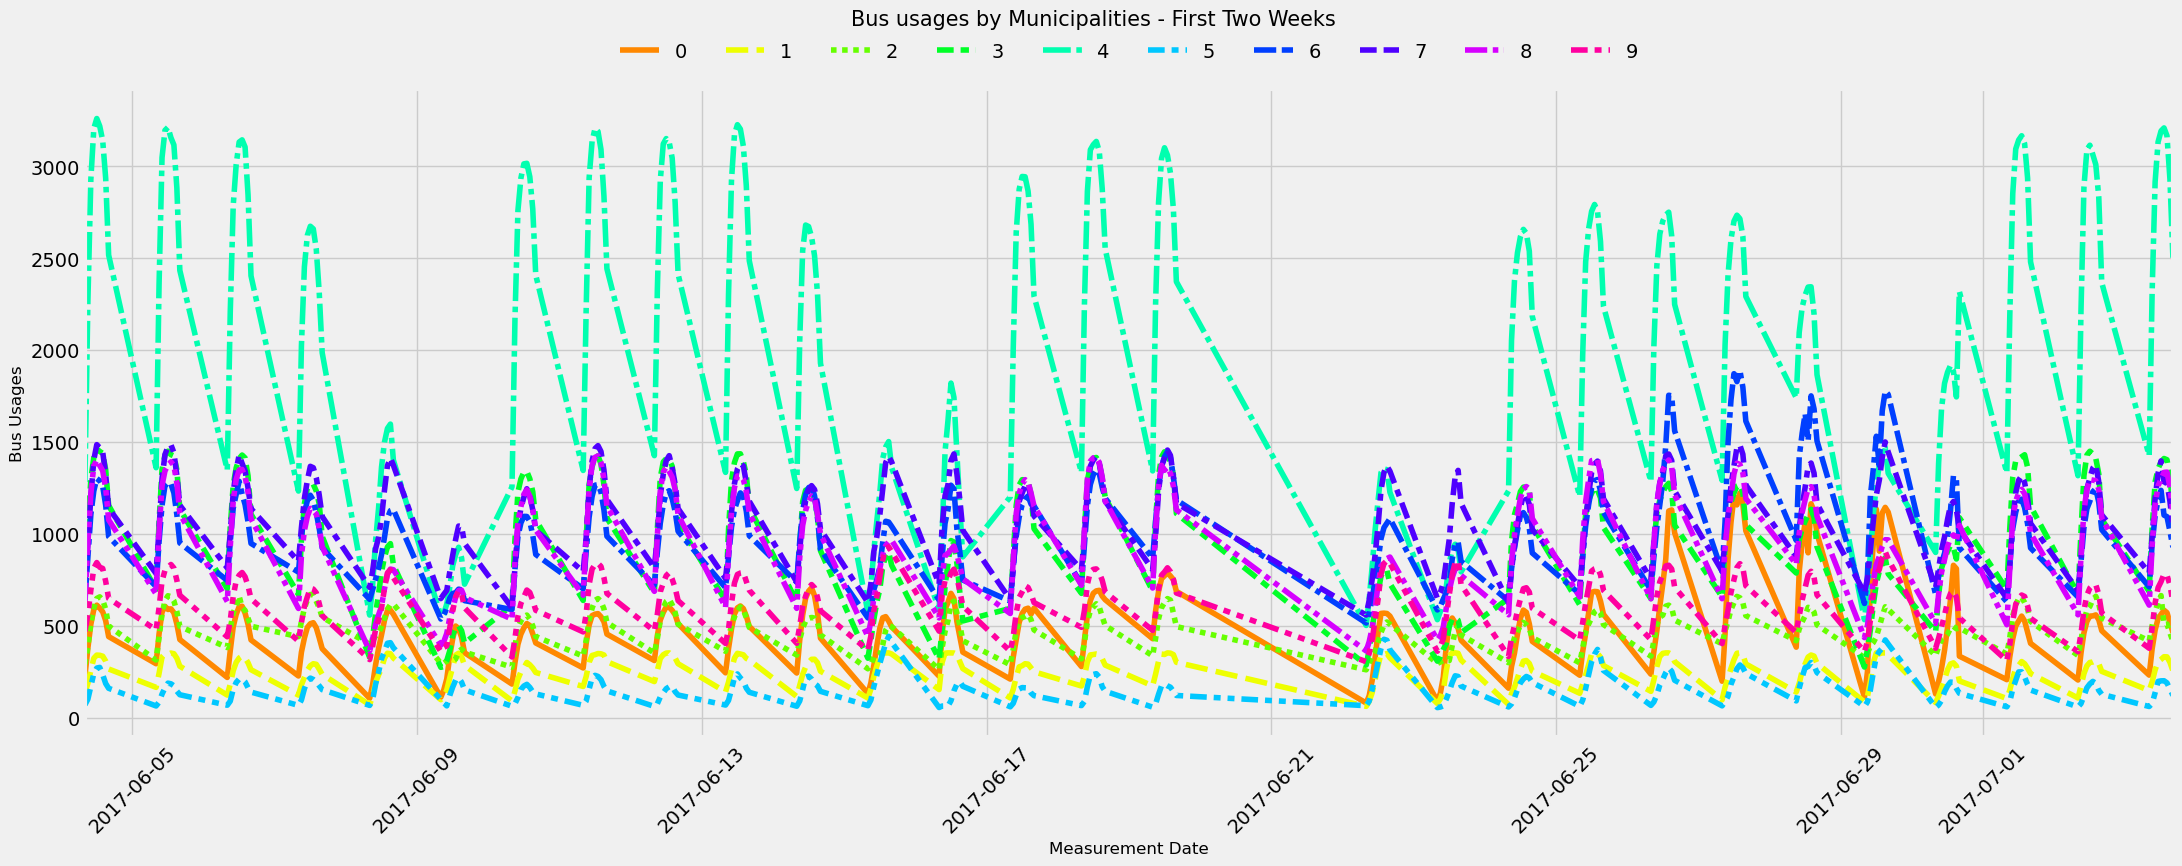

In [18]:
# got first month of the data and plot bus usages
first_weeks = pivot_df.loc[pivot_df.index < '2017-07-04']

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=first_weeks, palette="hsv")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False, ncol=len(first_weeks.columns))

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages by Municipalities - First Two Weeks", fontsize=15)
plt.xlim([first_weeks.index.min(), first_weeks.index.max()])
plt.xticks(rotation=45)

plt.show()

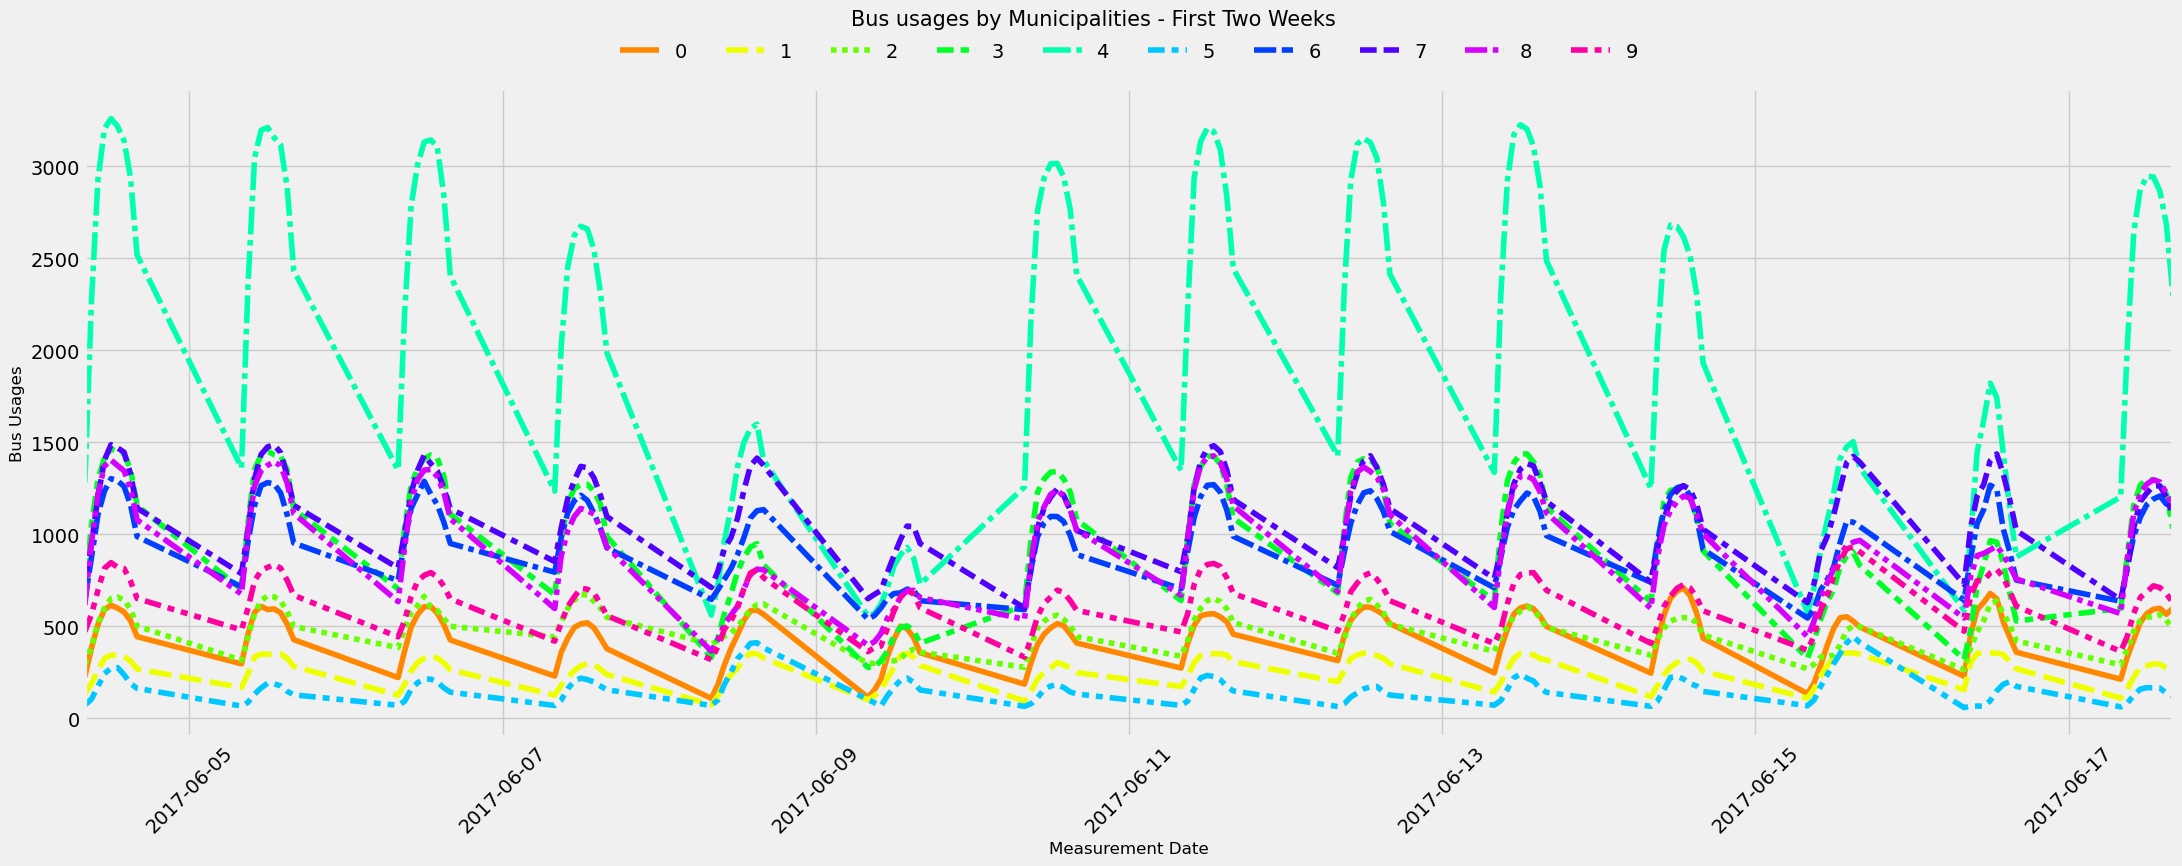

In [19]:
# got first two weeks of the data and plot bus usages
first_weeks = pivot_df.loc[pivot_df.index < '2017-06-18']

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=first_weeks, palette="hsv")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False, ncol=len(first_weeks.columns))

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages by Municipalities - First Two Weeks", fontsize=15)
plt.xlim([first_weeks.index.min(), first_weeks.index.max()])
plt.xticks(rotation=45)

plt.show()

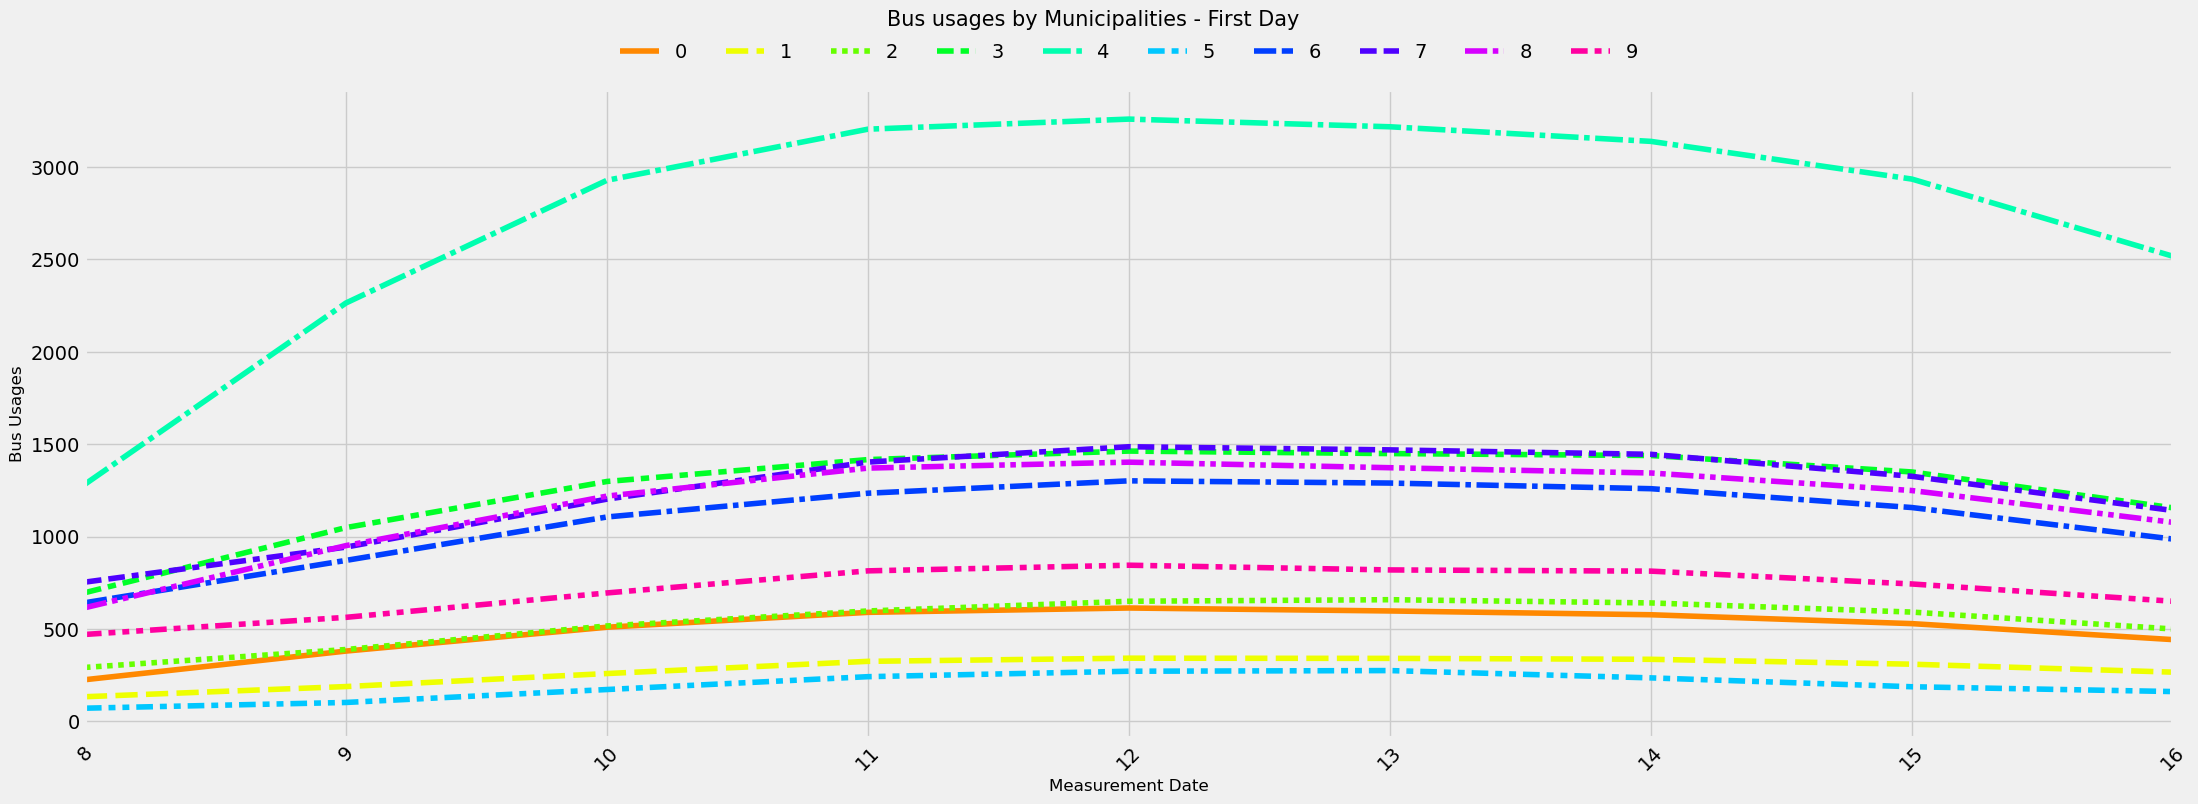

In [20]:
# got first day of the data and plot daily bus usages
first_day = pivot_df.loc[pivot_df.index < '2017-06-05']

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=first_day, palette="hsv")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), frameon=False, ncol=len(first_day.columns))

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages by Municipalities - First Day", fontsize=15)
plt.xlim([first_day.index.min(), first_day.index.max()])
plt.xticks(rotation=45)

labels = list(first_day.index.hour.unique())
ax.set_xticklabels(labels)

plt.show()

- It seems municipality 4 has the highest bus usage by far
- Also, we can see weekly pattern inside the data, so we should investigate it more after setting the baseline

# 3) Baseline Predictions

- Set a baseline performance by using municipality ids as feature and max_bus as target with time series indexes

In [21]:
# create a copy df for baseline and drop usage column to avoid data leakage
baseline_df = bus_df.copy(deep=True)

In [22]:
train_data_baseline = baseline_df.loc[baseline_df.index < test_date]
test_data_baseline = baseline_df.loc[baseline_df.index >= test_date]

#get features and target
X_train_baseline = train_data_baseline.drop(columns={"usage"}, axis=1)
y_train_baseline = train_data_baseline[["usage"]]

X_test_baseline = test_data_baseline.drop(columns={"usage"}, axis=1)
y_test_baseline = test_data_baseline[["usage"]]

In [23]:
'''
-- Use Linear Regression with default parameters for a baseline performance
-- Choose evaluation metrics as root mean squared error (RMSE) and R^2 Score (Coefficient of Determination)
'''

ridge_reg = LinearRegression()
ridge_reg.fit(X_train_baseline, y_train_baseline)

y_pred_baseline = ridge_reg.predict(X_test_baseline)

baseline_rmse = np.sqrt(mean_squared_error(y_test_baseline, y_pred_baseline))
baseline_r2 = r2_score(y_test_baseline, y_pred_baseline)
print(
    "Baseline RMSE: %.2f" % baseline_rmse,
    "\nBaseline R^2 Score: %.4f" % baseline_r2
    )

Baseline RMSE: 427.05 
Baseline R^2 Score: 0.5196


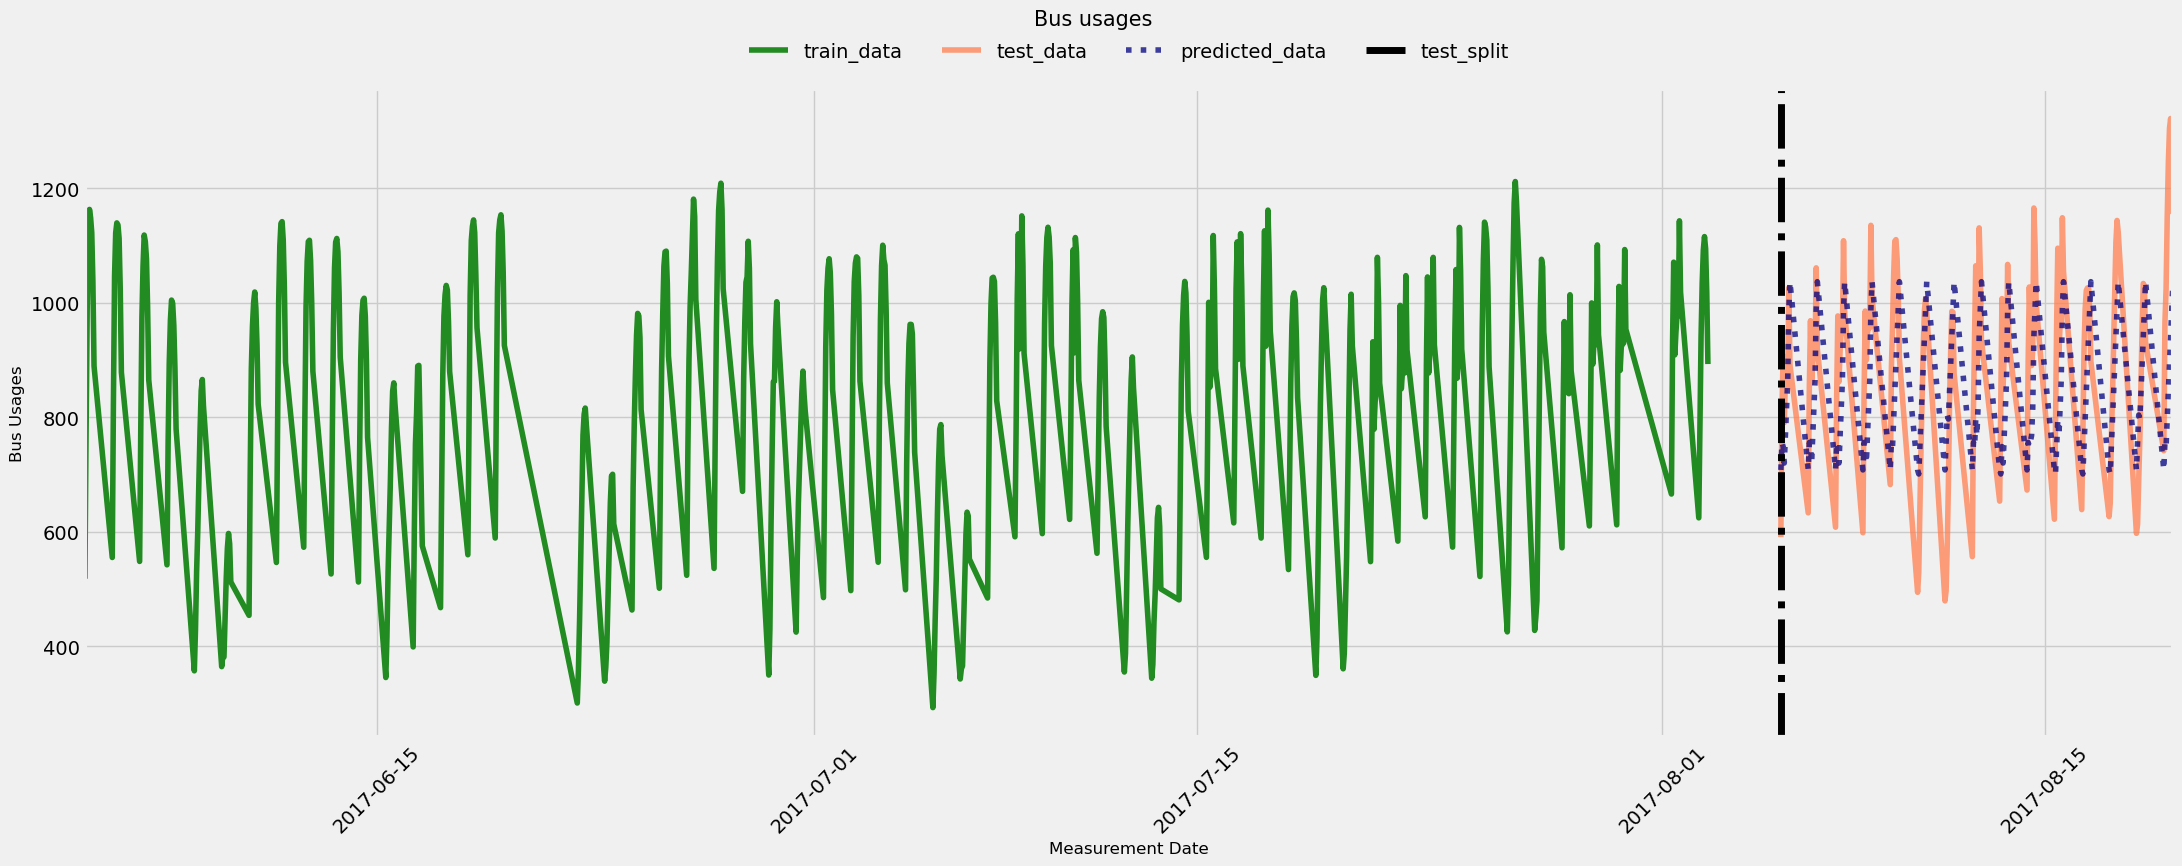

In [24]:
baseline_df = pd.DataFrame(data = y_pred_baseline, columns=y_test_baseline.columns, index=y_test_baseline.index)

# plot the time series bus usages through entire data by municipalities
train = bus_df.loc[bus_df.index < test_date]
test = bus_df.loc[bus_df.index >= test_date]

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=train, x=train.index, y="usage", errorbar=None, label="train_data", c="forestgreen")
sns.lineplot(data=test, x=test.index, y="usage", errorbar=None, label="test_data", alpha=0.75, c="coral")
sns.lineplot(data=baseline_df, x=baseline_df.index, y="usage", errorbar=None, label="predicted_data", alpha=0.75, ls="dotted", c="navy")

plt.axvline(test.index[0], lw=5, ls="dashdot", color="black", label="test_split") # add a line at test set date

plt.xlim([train.index.min(), test.index.max()])
plt.xticks(rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False)

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages", fontsize=15)
plt.show()

# 4) Feature Generation

- Add more features to the dataset to increase the baseline performance

In [25]:
# add a binary feature if usage that day is over the total_capacity or not
bus_df.reset_index(inplace=True)
bus_df["over_capacity"] = 0
over_cap = bus_df.query("usage > total_capacity")

bus_df.loc[over_cap.index, "over_capacity"] = 1
bus_df.set_index("timestamp", inplace=True)

bus_df

municipality_id   usage  total_capacity  hour  \
timestamp                                                            
2017-06-04 08:00:00                9   470.5            1332     8   
2017-06-04 08:00:00                8   615.0            2947     8   
2017-06-04 08:00:00                4  1283.0            3893     8   
2017-06-04 08:00:00                0   225.5            2813     8   
2017-06-04 08:00:00                7   753.5            2019     8   
...                              ...     ...             ...   ...   
2017-08-19 16:00:00                7  1402.0            2019    16   
2017-08-19 16:00:00                2   564.0             697    16   
2017-08-19 16:00:00                3  1259.5            1930    16   
2017-08-19 16:00:00                8  1223.0            2947    16   
2017-08-19 16:00:00                0  1273.5            2813    16   

                     over_capacity  
timestamp                           
2017-06-04 08:00:00              0  
2017-06-04 08:00:00              0  
2017-06-04 08:00:00              0  
2017-06-04 08:00:00              0  
2017-06-04 08:00:00              0  
...                            ...  
2017-08-19 16:00:00              0  
2017-08-19 16:00:00              0  
2017-08-19 16:00:00              0  
2017-08-19 16:00:00              0  
2017-08-19 16:00:00              0  

[6398 rows x 5 columns]

In [26]:
#count over capacity days
bus_df.value_counts("over_capacity")

over_capacity
0    6285
1     113
Name: count, dtype: int64

### Create Date Features

In [27]:
'''
-- Add date features from timestamp index
-- No year or year quarter feature since the dataset consists of only 2 months of the data
'''

bus_df["month"] = bus_df.index.month
bus_df["day"] = bus_df.index.day
bus_df["day_of_week"] = bus_df.index.day_of_week
bus_df["day_of_week_names"] = bus_df.index.day_name()
bus_df["is_weekend"] = bus_df["day_of_week_names"].apply(lambda x: 1 if x == "Saturday" or x == "Sunday" else 0)

bus_df

municipality_id   usage  total_capacity  hour  \
timestamp                                                            
2017-06-04 08:00:00                9   470.5            1332     8   
2017-06-04 08:00:00                8   615.0            2947     8   
2017-06-04 08:00:00                4  1283.0            3893     8   
2017-06-04 08:00:00                0   225.5            2813     8   
2017-06-04 08:00:00                7   753.5            2019     8   
...                              ...     ...             ...   ...   
2017-08-19 16:00:00                7  1402.0            2019    16   
2017-08-19 16:00:00                2   564.0             697    16   
2017-08-19 16:00:00                3  1259.5            1930    16   
2017-08-19 16:00:00                8  1223.0            2947    16   
2017-08-19 16:00:00                0  1273.5            2813    16   

                     over_capacity  month  day  day_of_week day_of_week_names  \
timestamp                                                                       
2017-06-04 08:00:00              0      6    4            6            Sunday   
2017-06-04 08:00:00              0      6    4            6            Sunday   
2017-06-04 08:00:00              0      6    4            6            Sunday   
2017-06-04 08:00:00              0      6    4            6            Sunday   
2017-06-04 08:00:00              0      6    4            6            Sunday   
...                            ...    ...  ...          ...               ...   
2017-08-19 16:00:00              0      8   19            5          Saturday   
2017-08-19 16:00:00              0      8   19            5          Saturday   
2017-08-19 16:00:00              0      8   19            5          Saturday   
2017-08-19 16:00:00              0      8   19            5          Saturday   
2017-08-19 16:00:00              0      8   19            5          Saturday   

                     is_weekend  
timestamp                        
2017-06-04 08:00:00           1  
2017-06-04 08:00:00           1  
2017-06-04 08:00:00           1  
2017-06-04 08:00:00           1  
2017-06-04 08:00:00           1  
...                         ...  
2017-08-19 16:00:00           1  
2017-08-19 16:00:00           1  
2017-08-19 16:00:00           1  
2017-08-19 16:00:00           1  
2017-08-19 16:00:00           1  

[6398 rows x 10 columns]

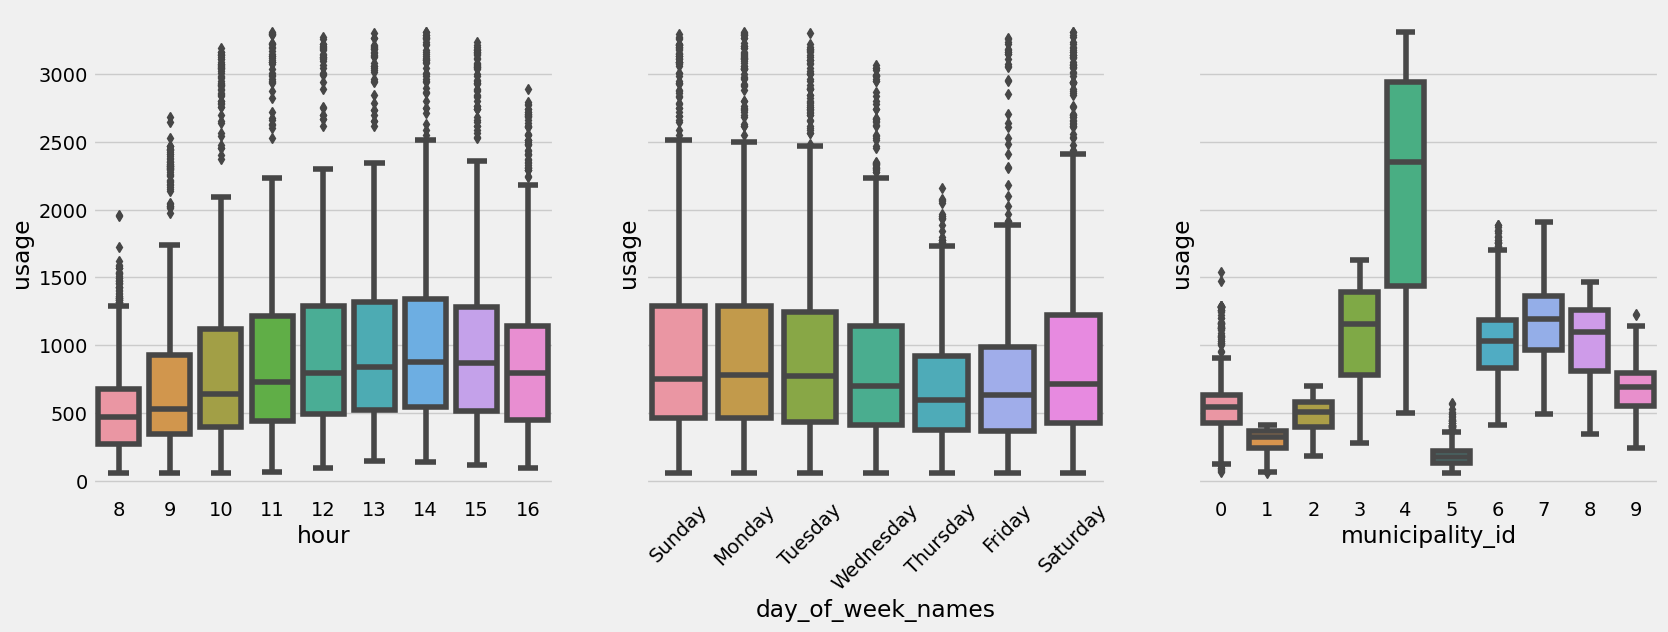

In [28]:
# plot new features to explore the dataset more

fig, ax = plt.subplots(1,3,figsize=(18,6), sharey=True)
sns.boxplot(data=bus_df, x="hour", y="usage", ax=ax[0])
sns.boxplot(data=bus_df, x="day_of_week_names", y="usage", ax=ax[1])
ax[1].tick_params(labelrotation=45)
sns.boxplot(data=bus_df, x="municipality_id", y="usage", ax=ax[2])
plt.show()

- Bus usages increase towards noon
- Middle of the weeks, bus usages are low, but increases towards weekends
- Municipality 4 has significantly higher bus usage while municipalities 1 and 5 have significantly lower bus usages

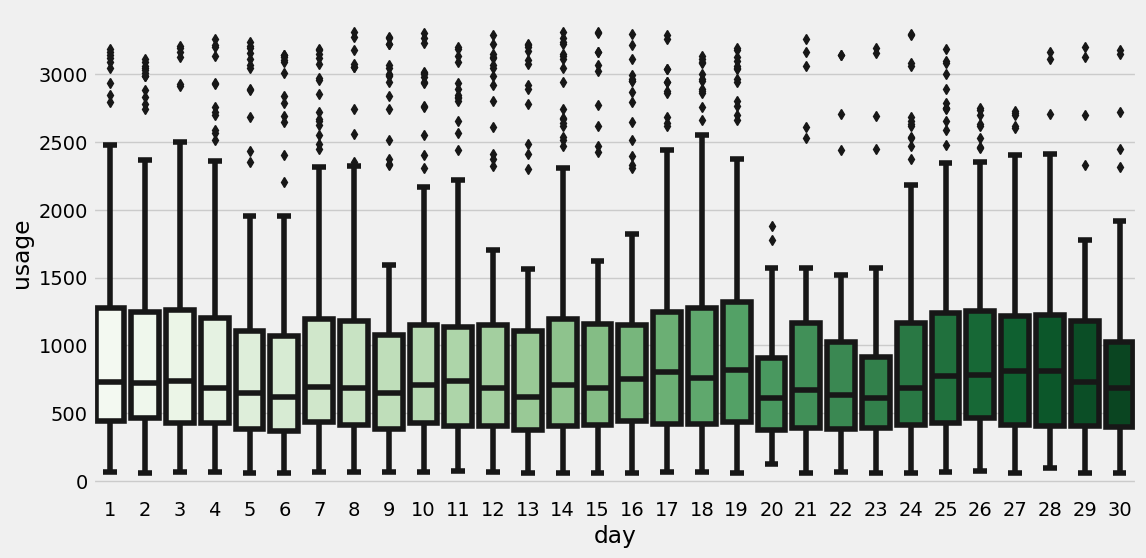

In [29]:
# plot each day of a month usages

fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(data=bus_df, x="day", y="usage", ax=ax, palette="Greens")
plt.show()

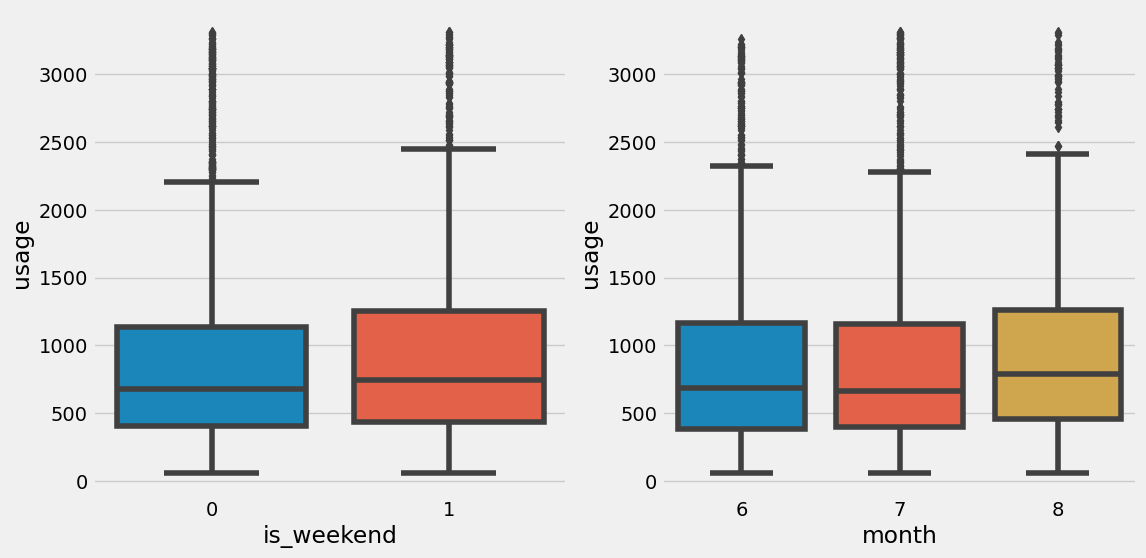

In [30]:
# plot weekend flag and months usage performances

fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(data=bus_df, x="is_weekend", y="usage", ax=ax[0])
sns.boxplot(data=bus_df, x="month", y="usage", ax=ax[1])
plt.show()

- Different days of month and different months, do not tell much about the bus usage patterns

### Create Lag Features

- We can create 1 hour 1 day and 1 week of lag features since we saw weekly patterns inside the data and our prediction horizon is 2 weeks

In [31]:
# add lag features by filtering municipalities to not confuse timestamp indexes for each municipality
lag_dfs = []

for municipality in set(bus_df["municipality_id"]):

    temp_df = bus_df[bus_df["municipality_id"] == municipality]

    target_map = temp_df["usage"].to_dict()

    temp_df["lag_1h"] = (temp_df.index - pd.Timedelta(hours=1)).map(target_map)
    temp_df["lag_1d"] = (temp_df.index - pd.Timedelta(days=1)).map(target_map)

    lag_dfs.append(temp_df)

concatanetad_df = pd.concat(lag_dfs).reset_index()[["timestamp", "municipality_id", "lag_1h", "lag_1d"]]
concatanetad_df.set_index("timestamp", inplace=True)
concatanetad_df.sort_values(by=["timestamp", "municipality_id"], inplace=True)

bus_df.sort_values(by=["timestamp", "municipality_id"], inplace=True)
bus_df = pd.concat([bus_df, concatanetad_df[["lag_1h", "lag_1d"]]], axis=1)
bus_df

municipality_id   usage  total_capacity  hour  \
timestamp                                                            
2017-06-04 08:00:00                0   225.5            2813     8   
2017-06-04 08:00:00                1   133.5             397     8   
2017-06-04 08:00:00                2   292.0             697     8   
2017-06-04 08:00:00                3   696.5            1930     8   
2017-06-04 08:00:00                4  1283.0            3893     8   
...                              ...     ...             ...   ...   
2017-08-19 16:00:00                5   220.5             587    16   
2017-08-19 16:00:00                6  1703.5            3113    16   
2017-08-19 16:00:00                7  1402.0            2019    16   
2017-08-19 16:00:00                8  1223.0            2947    16   
2017-08-19 16:00:00                9   847.0            1332    16   

                     over_capacity  month  day  day_of_week day_of_week_names  \
timestamp                                                                       
2017-06-04 08:00:00              0      6    4            6            Sunday   
2017-06-04 08:00:00              0      6    4            6            Sunday   
2017-06-04 08:00:00              0      6    4            6            Sunday   
2017-06-04 08:00:00              0      6    4            6            Sunday   
2017-06-04 08:00:00              0      6    4            6            Sunday   
...                            ...    ...  ...          ...               ...   
2017-08-19 16:00:00              0      8   19            5          Saturday   
2017-08-19 16:00:00              0      8   19            5          Saturday   
2017-08-19 16:00:00              0      8   19            5          Saturday   
2017-08-19 16:00:00              0      8   19            5          Saturday   
2017-08-19 16:00:00              0      8   19            5          Saturday   

                     is_weekend  lag_1h  lag_1d  
timestamp                                        
2017-06-04 08:00:00           1     NaN     NaN  
2017-06-04 08:00:00           1     NaN     NaN  
2017-06-04 08:00:00           1     NaN     NaN  
2017-06-04 08:00:00           1     NaN     NaN  
2017-06-04 08:00:00           1     NaN     NaN  
...                         ...     ...     ...  
2017-08-19 16:00:00           1   296.0   235.5  
2017-08-19 16:00:00           1  1809.5  1625.0  
2017-08-19 16:00:00           1  1590.0  1317.0  
2017-08-19 16:00:00           1  1325.5   940.5  
2017-08-19 16:00:00           1   965.0   798.5  

[6398 rows x 12 columns]

In [32]:
bus_df.isna().sum()

municipality_id        0
usage                  0
total_capacity         0
hour                   0
over_capacity          0
month                  0
day                    0
day_of_week            0
day_of_week_names      0
is_weekend             0
lag_1h               769
lag_1d               415
dtype: int64

- Null values for lag features are coming from the initial values since they do not have previous values

In [33]:
#drop day_of_week_names column since it will not provide any value to the model that we will built
bus_df.drop(columns={"day_of_week_names"}, inplace=True)

# 4) Final Model and Predictions

Apply:
- Hyperparameter Tuning
- Grid Search
- Time Series Cross Validation 

to the new features to predict the test dates' bus usages. The selected algorithm for the final model is XGBoost

### Train-Test Split

In [34]:
# last 2 weeks are the test set
train_data = bus_df.loc[bus_df.index < "2017-08-05"]
test_data = bus_df.loc[bus_df.index >= "2017-08-05"]

X_train = train_data.drop(columns="usage", axis=1)
y_train = train_data[["usage"]]

X_test = test_data.drop(columns="usage", axis=1)
y_test = test_data[["usage"]]

### Hyperparameter Tuning

In [35]:
'''
-- XGBoost - Hyperparameter tuning to find the best parameters
-- Select number of estimators as 200 to save time and later we will decide the optimal n_estimator by applying early stopping method
'''

params = { 
        'max_depth': [3, 6, 10],
        'colsample_bytree': [0.25, 0.5, 0.75],
        'subsample': [0.25, 0.5, 0.75],
        'min_split_loss': [0, 0.5, 0.75],
        'reg_alpha': [0, 0.5, 0.75],
        'reg_lambda': [0, 0.5, 0.75]
        }

xgb = XGBRegressor(
        learning_rate=0.5,
        n_estimators=200,
        objective='reg:squarederror', 
        eval_metric='rmse', 
        tree_method="auto", 
        n_jobs=-1
        )

grid = GridSearchCV(
        estimator=xgb,
        param_grid=params,
        scoring='neg_mean_squared_error',
        n_jobs=-1
        )

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'colsample_bytree': 0.75, 'max_depth': 3, 'min_split_loss': 0, 'reg_alpha': 0.5, 'reg_lambda': 0.75, 'subsample': 0.75}


### Time-Series Cross-Validation

In [36]:
scores_mse, scores_r2 = {}, {}

n_fold = 5

tss = TimeSeriesSplit(n_splits = n_fold)

xgb = XGBRegressor(
    max_depth=3,
    colsample_bytree=0.75,
    subsample=0.75,
    min_split_loss=0,
    reg_lambda=0.75,
    reg_alpha=0.5,
    learning_rate=0.01,
    n_estimators=5000,
    objective='reg:squarederror', 
    eval_metric='rmse', 
    tree_method="auto", 
    verbosity=1,
    early_stopping_rounds=30,
    n_jobs=-1
)

for (train_index, val_index), fold in zip(tss.split(X_train), range(1,n_fold+1)):
    X_train_fold, X_val_fold = X_train.iloc[train_index, :], X_train.iloc[val_index,:]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    xgb.fit(
        X_train_fold, y_train_fold,
        eval_set = [(X_val_fold, y_val_fold)],
        verbose=1000
        )

    y_pred = xgb.predict(X_val_fold)

    print(
        "\n---Fold: ", fold, "---", 
        "\nRMSE: %.4f" % np.sqrt(mean_squared_error(y_val_fold, y_pred)),
        "\nR2_Score: %.4f" % r2_score(y_val_fold, y_pred), "\n" ,sep=""
        )

    scores_mse[fold] = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    scores_r2[fold] = r2_score(y_val_fold, y_pred)

print(
    "Average RMSE: %.4f" % np.mean(list(scores_mse.values())),
    "\nAverage R2_Score: %.4f" % np.mean(list(scores_r2.values()))
)

[0]	validation_0-rmse:588.76887
[1000]	validation_0-rmse:98.73237
[1688]	validation_0-rmse:95.37336

---Fold: 1---
RMSE: 95.3699
R2_Score: 0.9740

[0]	validation_0-rmse:621.33097
[1000]	validation_0-rmse:93.71014
[1011]	validation_0-rmse:93.73801

---Fold: 2---
RMSE: 93.6142
R2_Score: 0.9776

[0]	validation_0-rmse:625.55875
[1000]	validation_0-rmse:133.83716
[2000]	validation_0-rmse:126.30181
[3000]	validation_0-rmse:122.06222
[4000]	validation_0-rmse:119.21011
[4711]	validation_0-rmse:117.91313

---Fold: 3---
RMSE: 117.9068
R2_Score: 0.9649

[0]	validation_0-rmse:619.50138
[1000]	validation_0-rmse:137.99992
[1924]	validation_0-rmse:127.25062

---Fold: 4---
RMSE: 127.2310
R2_Score: 0.9585

[0]	validation_0-rmse:626.32326
[1000]	validation_0-rmse:152.64136
[1914]	validation_0-rmse:142.68636

---Fold: 5---
RMSE: 142.6223
R2_Score: 0.9482

Average RMSE: 115.3489 
Average R2_Score: 0.9646


- We can observe from the folds that we can set n_estimators as 2500 on average for the final prediction

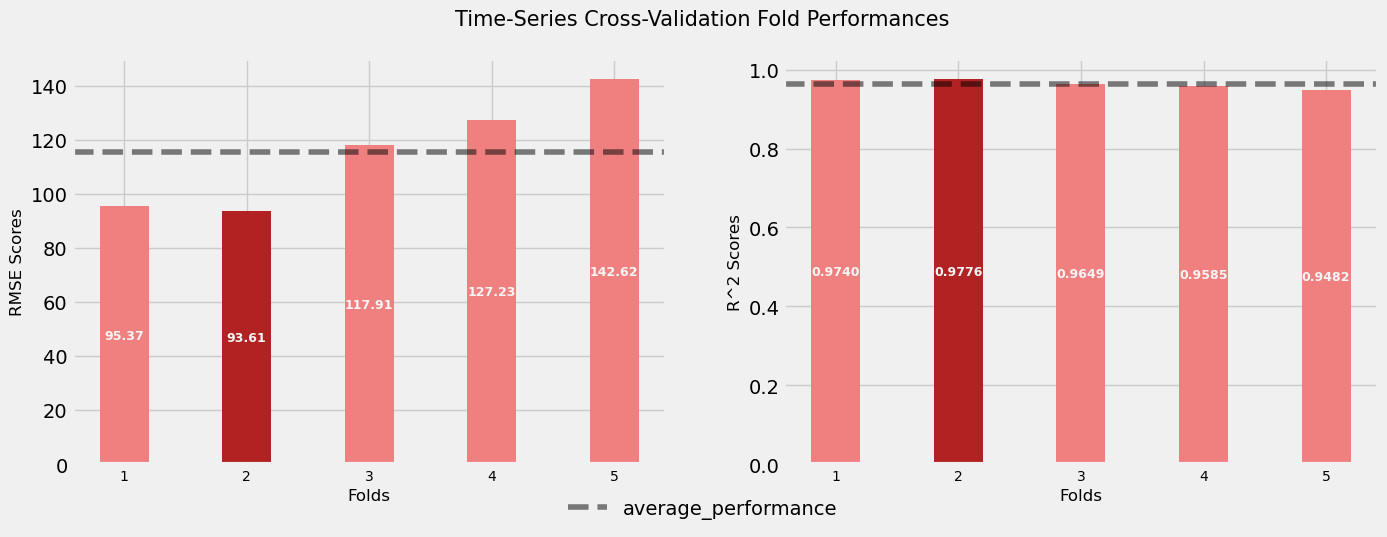

In [37]:
# plot cv results

fig, ax = plt.subplots(1,2,figsize=(15,5))

ind = np.arange(len(scores_mse)) + 0.3
width = 0.4

for i,score_dict in enumerate([scores_mse, scores_r2]): 
    scores = list(score_dict.values())

    bars = ax[i].bar(ind, scores, width, color="lightcoral")
    ax[i].bar_label(bars, fmt=('%.2f' if i==0 else '%.4f'), weight='bold', label_type='center', color='whitesmoke', fontsize=9, label="fold_performance")
    ax[i].patches[scores.index(min(scores)) if i==0 else scores.index(max(scores))].set_facecolor('firebrick') # Highlight the best resulted fold
    ax[i].axhline(np.mean(scores), ls="--", alpha=0.5, color="black", label=("average_performance" if i==0 else "_nolegend_")) # Draw a dashed line of the mean performance
    ax[i].set_xticks(ind, labels = score_dict.keys(), fontsize=10)
    ax[i].set_xlabel("Folds", fontsize=12)
    ax[i].set_ylabel("RMSE Scores" if i==0 else "R^2 Scores", fontsize=12)

fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.075), frameon=False)

fig.suptitle("Time-Series Cross-Validation Fold Performances", fontsize=15)
plt.show()

- Cross-validated results look way better than the baseline with tuned parameters of XGBoost

### Final Predictions Performance with the Test Set

In [38]:
# test set performance on tuned parameters
xgb = XGBRegressor(
    max_depth=3,
    colsample_bytree=0.75,
    subsample=0.75,
    min_split_loss=0,
    reg_lambda=0.75,
    reg_alpha=0.5,
    learning_rate=0.01,
    n_estimators=2500,
    objective='reg:squarederror', 
    eval_metric='rmse', 
    tree_method="auto", 
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

final_rmse =  np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print(
    "Final RMSE: %.4f" % final_rmse,
    "\nFinal R^2 Score: %.4f" % final_r2
    )

Final RMSE: 111.1657 
Final R^2 Score: 0.9674


In [39]:
# save the model

if not os.path.exists('model'):
    os.mkdir('model')

pickle.dump(xgb, open('model/xgboost_model', 'wb'))

### Feature Importances

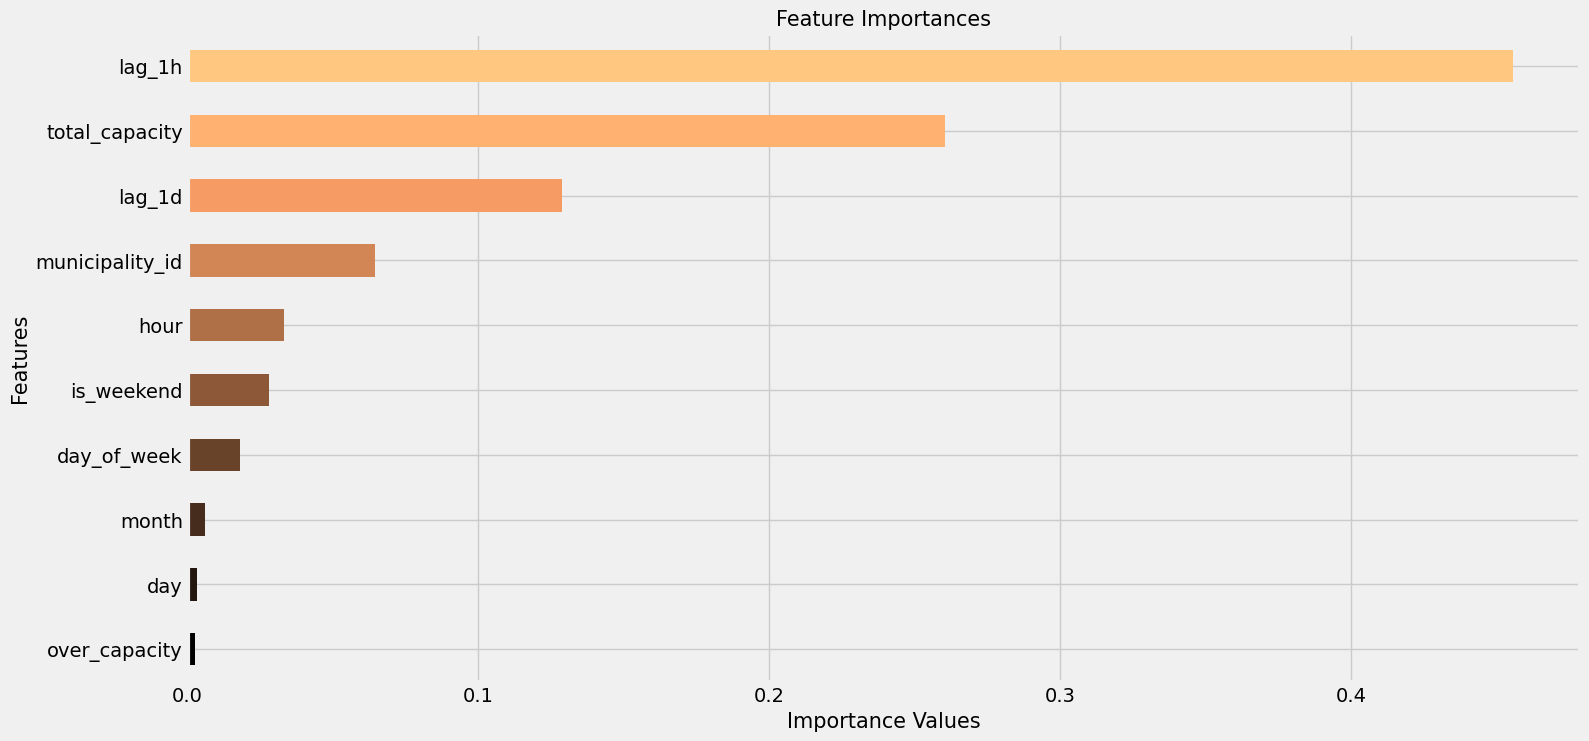

In [40]:
imp = xgb.feature_importances_

importances = pd.DataFrame({"feature": X_train.columns, "importance": imp})
importances = importances.sort_values(by="importance")

colors = mcp.gen_color(cmap='copper', n=len(importances))

ax = importances.plot(kind='barh', x='feature', y='importance', figsize=(16,8), color=colors, legend=False)
#ax.axvline(0.05, ls="--", color="firebrick")
plt.xlabel("Importance Values", fontsize=15)
plt.ylabel("Features", fontsize=15)
plt.title("Feature Importances", fontsize=15)
plt.show()

- Lag feature with 1-hour sliding window has the biggest importance over all features

### Predictions

In [41]:
# creating predictions dataframe
pred_df = pd.DataFrame({
    "municipality_id": test_data["municipality_id"].values,
    "usage": test_data["usage"].values,
    "predictions": y_pred
    }, index=y_test.index)

pred_df["error"] = np.abs(pred_df["usage"] - pred_df["predictions"])
pred_df.head()

municipality_id   usage  predictions       error
timestamp                                                            
2017-08-05 08:00:00                0   230.5   404.174225  173.674225
2017-08-05 08:00:00                1   149.5   190.037827   40.537827
2017-08-05 08:00:00                2   306.5   387.350464   80.850464
2017-08-05 08:00:00                3   695.5   582.859619  112.640381
2017-08-05 08:00:00                4  1957.0  1305.948608  651.051392

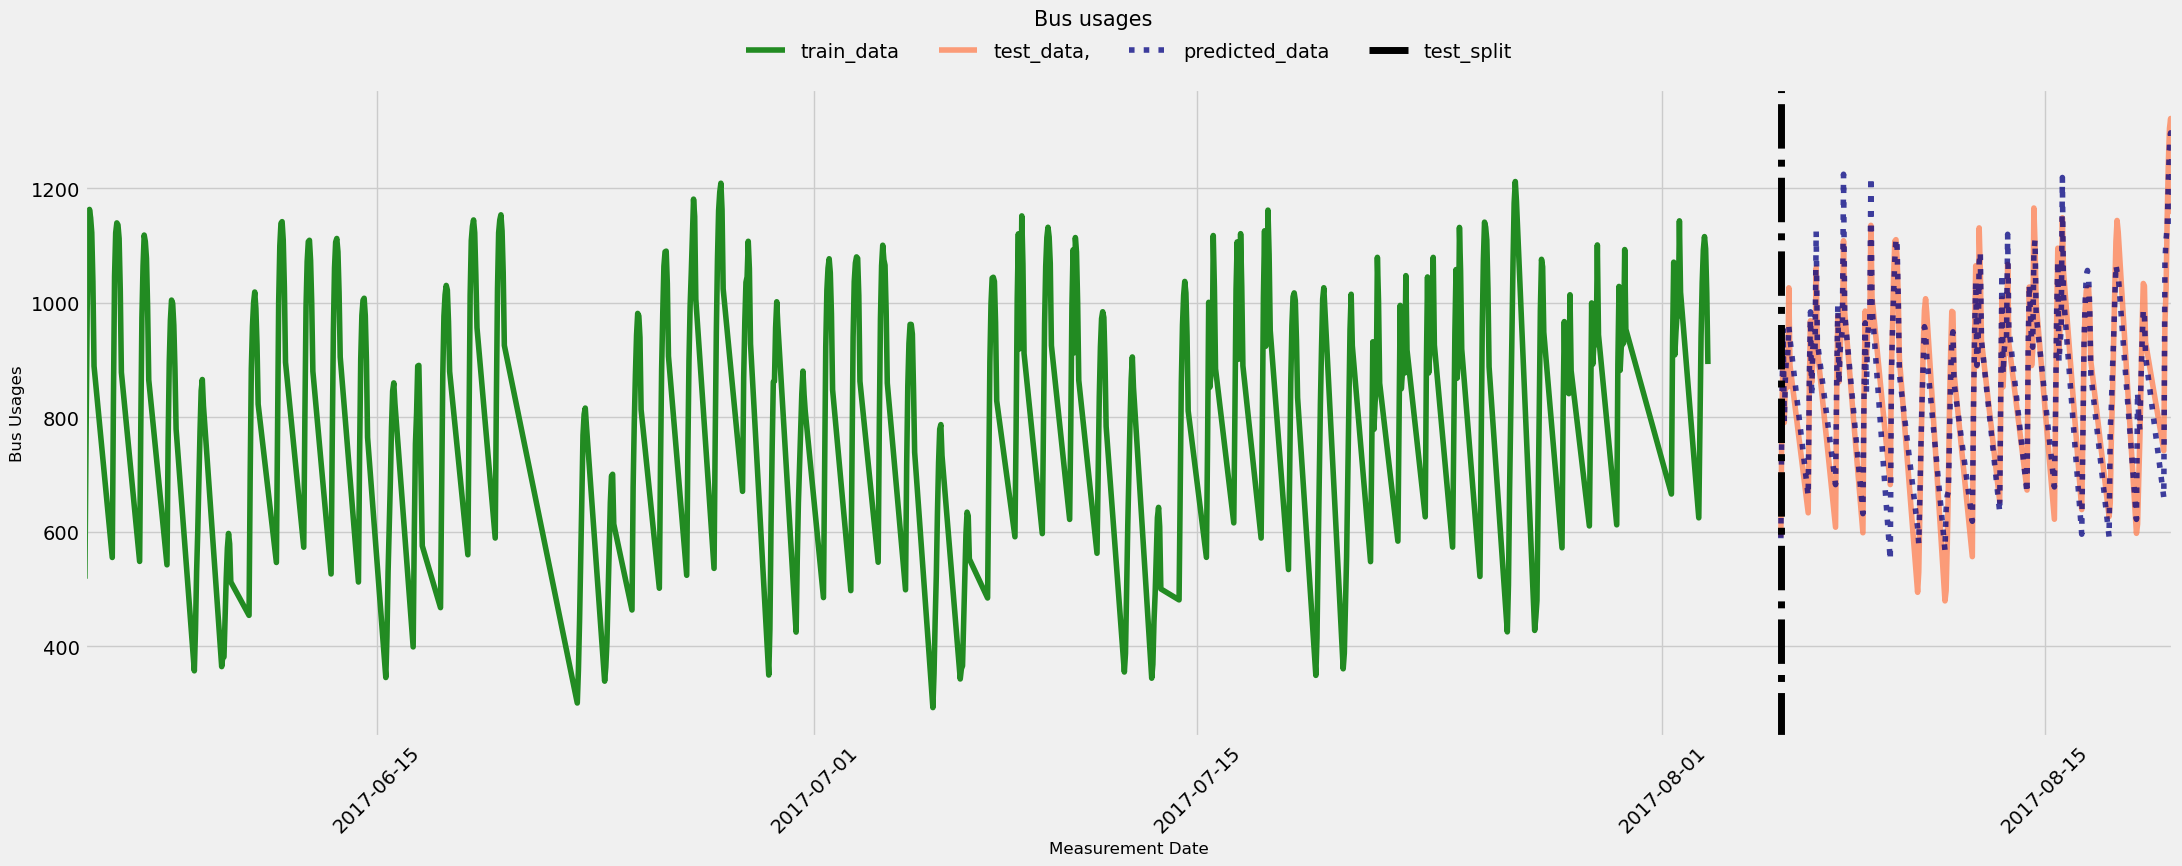

In [42]:
#plot actual and the predicted bus usages
train = bus_df.loc[bus_df.index < test_date]
test = bus_df.loc[bus_df.index >= test_date]

fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data=train, x=train.index, y="usage", errorbar=None, label="train_data", c="forestgreen")
sns.lineplot(data=pred_df, x=pred_df.index, y="usage", errorbar=None, label="test_data,", alpha=0.75, c="coral")
sns.lineplot(data=pred_df, x=pred_df.index, y="predictions", errorbar=None, label="predicted_data", alpha=0.75, ls="dotted", c="navy")

plt.axvline(test.index[0], lw=5, ls="dashdot", color="black", label="test_split") #add a line at test set date

plt.xlim([train.index.min(), test.index.max()])
plt.xticks(rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False)

plt.xlabel("Measurement Date", fontsize=12)
plt.ylabel("Bus Usages", fontsize=12)

fig.suptitle("Bus usages", fontsize=15)
plt.show()

- The final model performance looks like having more overlapped predictions with the test data than the baseline

### Residual Analysis

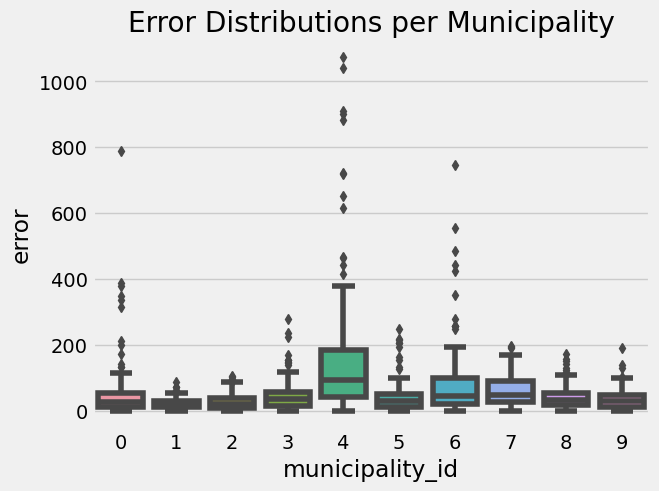

In [43]:
# Error distributions

sns.boxplot(data=pred_df, x="municipality_id", y="error")
plt.title("Error Distributions per Municipality")
plt.show()

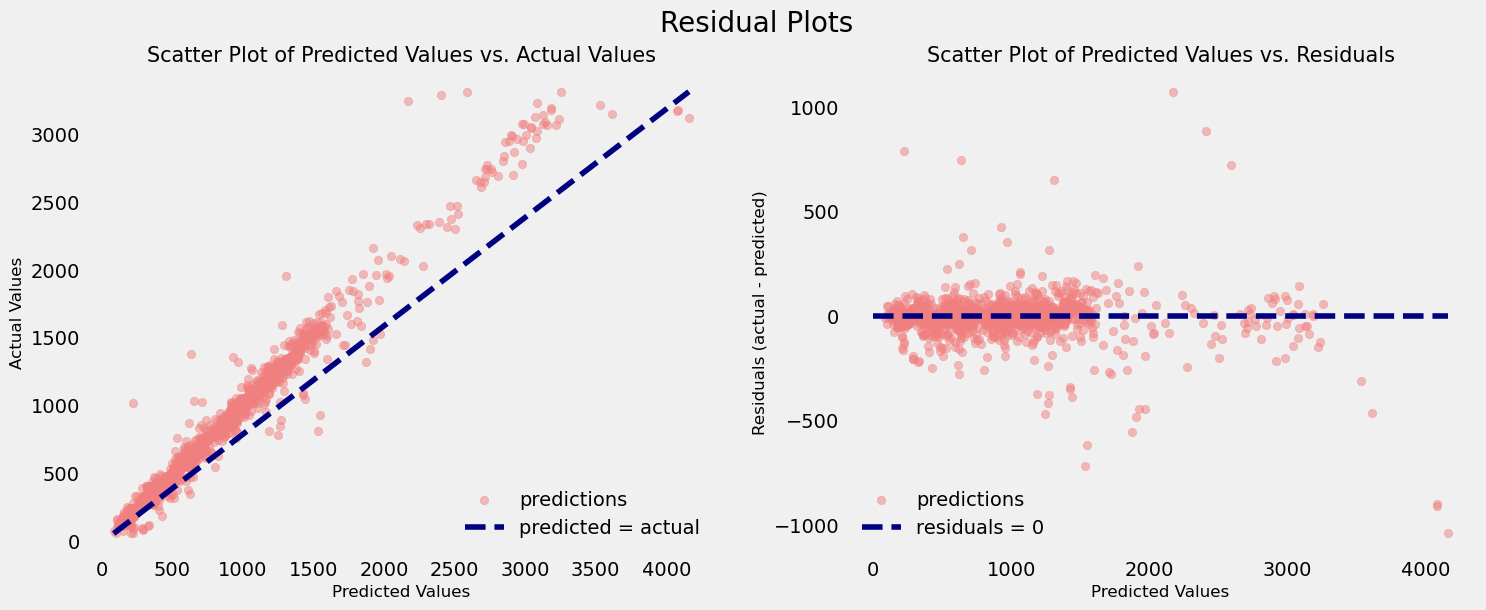

In [44]:
# Residual plots

residuals = [t-p for p,t in zip(y_pred, y_test["usage"].values)]

fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].scatter(x=y_pred, y=y_test["usage"].values, alpha=0.5, color="lightcoral", label="predictions")
ax[0].plot([min(y_pred), max(y_pred)], [min(y_test["usage"].values), max(y_test["usage"].values)], ls="dashed", color="navy", label="predicted = actual")
ax[0].legend(loc="lower right", frameon=False)

ax[0].set_xlabel("Predicted Values", fontsize=12)
ax[0].set_ylabel("Actual Values", fontsize=12)
ax[0].set_title("Scatter Plot of Predicted Values vs. Actual Values", fontsize=15)
ax[0].grid(visible=False)


ax[1].scatter(x=y_pred, y=residuals, alpha=0.5, color="lightcoral", label="predictions")
ax[1].plot([0, max(y_pred)], [0,0], ls="dashed", color="navy", label="residuals = 0")
ax[1].legend(loc="lower left", frameon=False)

ax[1].set_xlabel("Predicted Values", fontsize=12)
ax[1].set_ylabel("Residuals (actual - predicted)", fontsize=12)
ax[1].set_title("Scatter Plot of Predicted Values vs. Residuals", fontsize=15)
ax[1].grid(visible=False)

fig.suptitle("Residual Plots", fontsize=20)
plt.show()

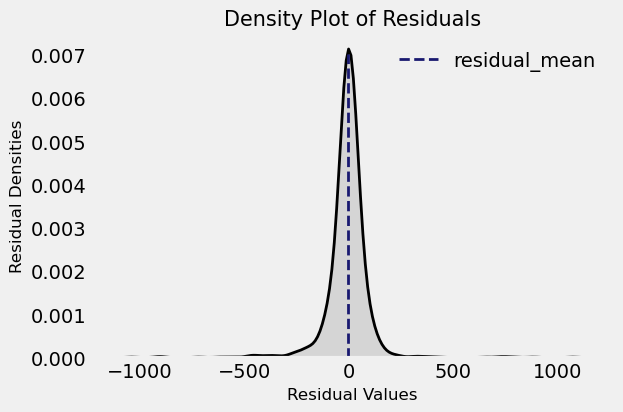

In [45]:
# Residual distributions

fig, ax = plt.subplots(figsize=(6,4))

ax = sns.kdeplot(residuals, shade=False, color="black", linewidth=2)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

height = np.interp(np.mean(residuals), xs, ys)
ax.vlines(np.mean(residuals), 0, height, color='midnightblue', ls='dashed', lw=2, label="residual_mean")

ax.fill_between(xs, 0, ys, facecolor='dimgrey', alpha=0.2)

ax.legend(loc="best", frameon=False)

ax.set_xlabel("Residual Values", fontsize=12)
ax.set_ylabel("Residual Densities", fontsize=12)
ax.set_title("Density Plot of Residuals", fontsize=15)
ax.grid(visible=False)
plt.show()